# Modèles prédictifs du nombre de vélibs d'un point de vue spatial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import prettytable as ptbl


Bad key "text.kerning_factor" on line 4 in
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
velib = pd.read_csv(r"/Users/Romain/Documents/Romain/ENSAE 2A 2020-2021/Stat'App/Github Stat'App/velib_nombre.csv")
velib = velib.drop(['Unnamed: 0'], axis = 1)
velib

,10/19/20;18:56:54,10/19/20;19:56:58,10/19/20;20:57:02,10/19/20;21:57:05,10/19/20;22:57:14,10/19/20;23:57:18,10/20/20;00:57:22,10/20/20;01:57:26,10/20/20;02:57:30,10/20/20;03:57:34,...,02/15/21;11:49:48,02/15/21;12:53:25,02/15/21;13:56:59,02/15/21;15:00:34,02/15/21;16:04:08,02/15/21;17:07:43,02/15/21;18:11:18,02/15/21;19:16:38,02/15/21;20:20:06,02/15/21;21:23:35
0,1,2,5,4,3,3,3,3,2,2,...,2,2,2,1,2,4,2,5,3,4
1,45,48,49,51,52,52,52,52,52,45,...,37,37,39,41,40,38,32,25,24,24
2,2,3,10,9,11,9,9,9,9,9,...,1,1,0,4,4,1,1,4,5,3
3,6,9,10,12,10,10,11,11,11,11,...,6,5,8,8,5,4,6,4,5,8
4,7,16,25,24,23,24,24,24,24,24,...,6,3,4,2,2,4,6,11,17,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,15,25,27,31,32,33,33,32,32,33,...,22,21,21,19,21,23,30,34,36,36
1394,2,2,0,14,16,16,16,16,16,16,...,2,3,3,4,5,6,8,9,9,11
1395,6,15,29,34,35,35,35,35,35,35,...,8,8,13,9,8,7,10,22,25,29
1396,17,15,12,15,12,12,12,12,12,12,...,11,11,16,14,14,14,15,7,9,8


On dispose d'une base de données nettoyées avec un échantillonnage par heure sur toutes les stations Vélib d'Ile-de-France. 

Avant de commencer les analyses, on garde toutefois le numéro des stations ainsi que leurs informations : 

In [3]:
# Import des librairies pour importer les données open data au format Json
import urllib.request
import json
from pandas.io.json import json_normalize

In [4]:
request= urllib.request.Request('https://velib-metropole-opendata.smoove.pro/opendata/Velib_Metropole/station_information.json')
response = urllib.request.urlopen(request)
station_info = response.read()
data = json.loads(station_info)
df_station_info = json_normalize(data['data']['stations'])
df_station_info.head()

,station_id,name,lat,lon,capacity,stationCode,rental_methods
0,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,16107,NaN
1,99950133,André Mazet - Saint-André des Arts,48.853756,2.339096,55,6015,[CREDITCARD]
2,516709288,Charonne - Robert et Sonia Delauney,48.855908,2.392571,20,11104,NaN
3,36255,Toudouze - Clauzel,48.879296,2.337360,21,9020,[CREDITCARD]
4,37815204,Mairie du 12ème,48.840855,2.387555,30,12109,NaN


In [5]:
df_id_name_capacity = df_station_info[["station_id", "lat", "lon", "name", "capacity"]]
velib_details = df_id_name_capacity.merge(velib, how = "inner", left_index=True, right_index=True)
#velib_w_capacity = velib_w_capacity[velib_w_capacity["capacity"] != 0]

In [6]:
velib_details[:10]

,station_id,lat,lon,name,capacity,10/19/20;18:56:54,10/19/20;19:56:58,10/19/20;20:57:02,10/19/20;21:57:05,10/19/20;22:57:14,...,02/15/21;11:49:48,02/15/21;12:53:25,02/15/21;13:56:59,02/15/21;15:00:34,02/15/21;16:04:08,02/15/21;17:07:43,02/15/21;18:11:18,02/15/21;19:16:38,02/15/21;20:20:06,02/15/21;21:23:35
0,213688169,48.865983,2.275725,Benjamin Godard - Victor Hugo,35,1,2,5,4,3,...,2,2,2,1,2,4,2,5,3,4
1,99950133,48.853756,2.339096,André Mazet - Saint-André des Arts,55,45,48,49,51,52,...,37,37,39,41,40,38,32,25,24,24
2,516709288,48.855908,2.392571,Charonne - Robert et Sonia Delauney,20,2,3,10,9,11,...,1,1,0,4,4,1,1,4,5,3
3,36255,48.879296,2.337360,Toudouze - Clauzel,21,6,9,10,12,10,...,6,5,8,8,5,4,6,4,5,8
4,37815204,48.840855,2.387555,Mairie du 12ème,30,7,16,25,24,23,...,6,3,4,2,2,4,6,11,17,18
5,100769544,48.851519,2.343670,Harpe - Saint-Germain,46,38,26,18,20,24,...,26,25,29,26,27,27,28,28,28,29
6,85002689,48.819428,2.343335,Jourdan - Stade Charléty,60,19,23,19,29,30,...,6,11,11,10,10,9,11,17,18,20
7,54000559,48.881973,2.301132,Jouffroy d'Abbans - Wagram,40,9,8,5,7,7,...,13,13,15,10,10,10,17,17,15,15
8,85043758,48.882878,2.287667,Guersant - Gouvion-Saint-Cyr,29,4,10,11,14,14,...,29,27,29,28,30,31,35,37,38,38
9,123095125,48.871044,2.366104,Alibert - Jemmapes,60,13,25,37,36,36,...,25,22,18,13,14,13,21,26,28,33


In [67]:
df_velib = velib.transpose()
df_velib

,0,1,2,3,4,5,6,7,8,9,...,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397
10/19/20;18:56:54,1,45,2,6,7,38,19,9,4,13,...,6,4,2,38,18,15,2,6,17,17
10/19/20;19:56:58,2,48,3,9,16,26,23,8,10,25,...,7,6,1,21,20,25,2,15,15,13
10/19/20;20:57:02,5,49,10,10,25,18,19,5,11,37,...,5,12,1,18,17,27,0,29,12,5
10/19/20;21:57:05,4,51,9,12,24,20,29,7,14,36,...,6,14,2,17,19,31,14,34,15,6
10/19/20;22:57:14,3,52,11,10,23,24,30,7,14,36,...,6,13,0,18,19,32,16,35,12,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/15/21;17:07:43,4,38,1,4,4,27,9,10,31,13,...,3,10,2,15,11,23,6,7,14,22
02/15/21;18:11:18,2,32,1,6,6,28,11,17,35,21,...,5,11,2,11,11,30,8,10,15,11
02/15/21;19:16:38,5,25,4,4,11,28,17,17,37,26,...,11,16,3,11,12,34,9,22,7,6
02/15/21;20:20:06,3,24,5,5,17,28,18,15,38,28,...,10,18,1,13,12,36,9,25,9,5


## Construction de la variable à prédire : le nombre de vélos dans une station target **1 jour** plus tard

In [157]:
df = df_velib.copy()
df['y'] = df[0]
df

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,y
10/19/20;18:56:54,1,45,2,6,7,38,19,9,4,13,...,4,2,38,18,15,2,6,17,17,1
10/19/20;19:56:58,2,48,3,9,16,26,23,8,10,25,...,6,1,21,20,25,2,15,15,13,2
10/19/20;20:57:02,5,49,10,10,25,18,19,5,11,37,...,12,1,18,17,27,0,29,12,5,5
10/19/20;21:57:05,4,51,9,12,24,20,29,7,14,36,...,14,2,17,19,31,14,34,15,6,4
10/19/20;22:57:14,3,52,11,10,23,24,30,7,14,36,...,13,0,18,19,32,16,35,12,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/15/21;17:07:43,4,38,1,4,4,27,9,10,31,13,...,10,2,15,11,23,6,7,14,22,4
02/15/21;18:11:18,2,32,1,6,6,28,11,17,35,21,...,11,2,11,11,30,8,10,15,11,2
02/15/21;19:16:38,5,25,4,4,11,28,17,17,37,26,...,16,3,11,12,34,9,22,7,6,5
02/15/21;20:20:06,3,24,5,5,17,28,18,15,38,28,...,18,1,13,12,36,9,25,9,5,3


In [158]:
axis = df_velib.index

# Boucle qui met dans Y toutes les données 24h plus tard
for i in range(len(df)-24):
    df['y'][axis[i]] = df[0][axis[i+24]]

# Puis on supprime les 24 dernières lignes qui ne peuvent pas être complétées
df.drop(axis[-24:], inplace = True)
df

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,y
10/19/20;18:56:54,1,45,2,6,7,38,19,9,4,13,...,4,2,38,18,15,2,6,17,17,4
10/19/20;19:56:58,2,48,3,9,16,26,23,8,10,25,...,6,1,21,20,25,2,15,15,13,5
10/19/20;20:57:02,5,49,10,10,25,18,19,5,11,37,...,12,1,18,17,27,0,29,12,5,4
10/19/20;21:57:05,4,51,9,12,24,20,29,7,14,36,...,14,2,17,19,31,14,34,15,6,4
10/19/20;22:57:14,3,52,11,10,23,24,30,7,14,36,...,13,0,18,19,32,16,35,12,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/14/21;15:43:31,1,30,3,8,12,42,4,9,33,40,...,11,2,12,19,16,3,18,5,20,4
02/14/21;16:47:04,2,39,1,8,11,37,5,7,33,40,...,9,4,14,17,15,5,16,5,20,2
02/14/21;17:50:32,4,35,1,10,16,38,4,11,30,36,...,9,4,11,12,22,7,17,8,15,5
02/14/21;18:53:59,7,40,2,7,20,38,8,13,33,46,...,15,2,9,11,33,5,18,12,12,3


## Machine Learning basique : regarder ce qu'il se passe sur une station

In [159]:
# Choix des features
stations = [i for i in df.columns if i != 'y']
X = df[stations]

# Préparation de la target
y = df['y']

In [160]:
# Régression linéaire simple
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_prediction = regressor.predict(X_test)

print("Le MAE du modèle est "+str(round(mean_absolute_error(y_test, y_prediction),3))+" avec la régression linéaire")

Le MAE du modèle est 6.703 avec la régression linéaire


In [162]:
# Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
regressor = RandomForestRegressor(max_depth = 5, min_samples_split = 4, n_estimators = 50)
regressor.fit(X_train, y_train)
y_prediction = regressor.predict(X_test)

print("Le MAE du modèle est "+str(round(mean_absolute_error(y_test, y_prediction),3))+" avec random forest")

Le MAE du modèle est 2.938 avec random forest


## Réalisation d'un apprentissage pour 10 stations aléatoires (les premières dans l'ordre des données) : automatisation

In [84]:
# Import du module de visualisation des résultats
from prettytable import PrettyTable

In [85]:
# Liste des stations cibles
stations_tests = []
for i in range(10):
    stations_tests.append("station_"+str(i))
stations_tests

['station_0',
 'station_1',
 'station_2',
 'station_3',
 'station_4',
 'station_5',
 'station_6',
 'station_7',
 'station_8',
 'station_9']

## Visualisation des données sélectionnées

In [272]:
import folium

# Titre : 
loc = 'Les 10 stations Velib selectionnees'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   

stations_velib_paris = folium.Map(location = [48.856578, 2.351828], zoom_start = 12.5) # On centre sur Paris
for i in range(10): # Affichage des 10 premières stations considérées
    
    test_mark  = '<head><meta http-equiv="Content-Type" content="text/html; charset=windows-1252"></head>'
    test_mark += '<strong>'+stations_tests[i] + " " + df_station_info['name'][i] + ". Capacite = "+str(velib_details['capacity'][i])+'<strong>'

    folium.Marker(
        np.array([df_station_info['lat'][i],df_station_info['lon'][i]]).tolist(),
        #popup = stations_tests[i] + " " + df_station_info['name'][i] + ". Capacite = "+str(velib_details['capacity'][i]), 
        popup = test_mark, 
        icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(stations_velib_paris)

stations_velib_paris.get_root().html.add_child(folium.Element(title_html))

stations_velib_paris

## Machine Learning

In [303]:
# Stockage des index du dataframe
axis = df_velib.index
# Préparation des résultats à stocker : pour chaque station, on garde le numéro de la station dans le dataframe df_velib, le modèle de 
# régression linéaire et de random forest
resultats = {}

# Préparation de la visualisation des résultats :
ptbl = PrettyTable()
ptbl.field_names = ["Station target", "Mean(Occupation) - test", "Std(Occupation) - test", "MAE LR - test", "MAE RF - test", "MAE méthode intuitive - test"]

# Dataframe pour la Régression Linéaire et le Random Forest
for i in range(len(stations_tests)):
    df = df_velib.copy()
    df['y'] = df[i]

    for j in range(len(df)-24):
        df['y'][axis[j]] = df[i][axis[j+24]]
        
    # Puis on supprime les 24 dernières lignes qui ne peuvent pas être complétées
    df.drop(axis[-24:], inplace = True)

    # Machine Learning
    stations_features = [i for i in df.columns if i != 'y']
    X = df[stations_features]
    # Préparation de la target
    y = df['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)

    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor(max_depth = 5, min_samples_split = 5, n_estimators = 50)
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[i], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[i].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[i].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[i])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats[stations_tests[i]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl.add_row([stations_tests[i], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl)
print("Résultats des MAE sur le test")

+----------------+-------------------------+------------------------+---------------+---------------+------------------------------+
| Station target | Mean(Occupation) - test | Std(Occupation) - test | MAE LR - test | MAE RF - test | MAE méthode intuitive - test |
+----------------+-------------------------+------------------------+---------------+---------------+------------------------------+
|   station_0    |           5.31          |          3.92          |      6.7      |      2.92     |             3.45             |
|   station_1    |          30.71          |          13.3          |     16.93     |      8.57     |             9.53             |
|   station_2    |           4.31          |          2.95          |      7.27     |      2.34     |             2.82             |
|   station_3    |           5.57          |          3.63          |      7.78     |      2.8      |             3.41             |
|   station_4    |          16.79          |          8.21          |

### Un peu de data viz

In [287]:
def ajout_categorie(df):
    """
    Ajoute une colonne 'categorie' à un dataframe utilisé pour le machine learning. 
    Les valeurs sont des strings : ou bien 'train' ou bien 'test'
    """
    df['categorie'] = 0
    df_index = df.index
    separation = np.floor(0.7*len(df))

    for i in range(len(df)):
        if i <= separation:
            df['categorie'][df_index[i]] = 'train'
        else:
            df['categorie'][df_index[i]] = 'test'

In [304]:
def ajout_numero(numero,df):
    """
    Ajoute le numéro de la station target
    """
    df['num_station_target'] = 0
    df['num_station_target'] = str(numero)

In [316]:
les_dfs = []
for i in range(10):
    df = X[i].copy()
    df = pd.DataFrame(df)
    df['nb_velibs'] = 0
    df['nb_velibs'] = df[i]
    del df[i]
    ajout_categorie(df)
    ajout_numero(i,df)
    les_dfs.append(df)

#les_dfs[0]

In [318]:
tous_les_dfs = pd.concat(les_dfs)
tous_les_dfs

,nb_velibs,categorie,num_station_target
10/19/20;18:56:54,1,train,0
10/19/20;19:56:58,2,train,0
10/19/20;20:57:02,5,train,0
10/19/20;21:57:05,4,train,0
10/19/20;22:57:14,3,train,0
...,...,...,...
02/14/21;15:43:31,40,test,9
02/14/21;16:47:04,40,test,9
02/14/21;17:50:32,36,test,9
02/14/21;18:53:59,46,test,9


Text(0, 0.5, 'Nombre de vélos sur la période considérée')

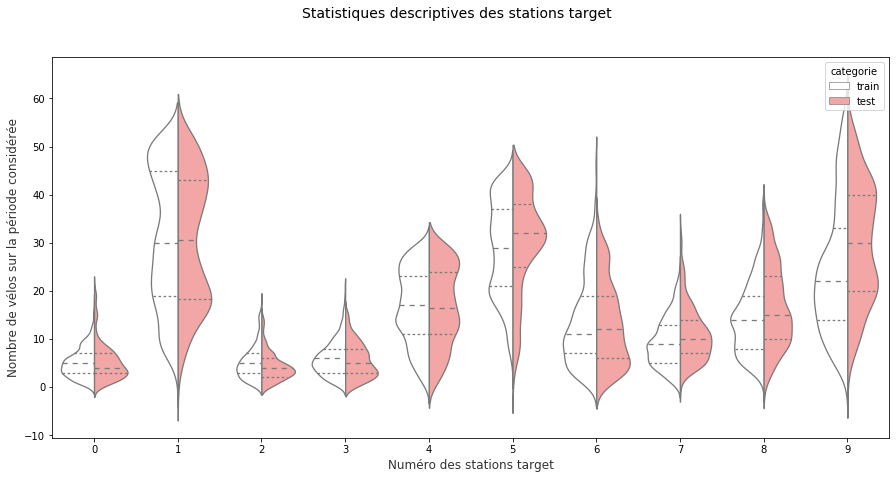

In [323]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
f.suptitle('Statistiques descriptives des stations target', fontsize=14)

sns.violinplot(x = 'num_station_target', y = 'nb_velibs',data=tous_les_dfs, hue = 'categorie', split=True, inner='quart', linewidth=1.3, ax=ax, palette={'test': '#FF9999', 'train': 'white'})
ax.set_xlabel("Numéro des stations target",size = 12,alpha=0.8)
ax.set_ylabel("Nombre de vélos sur la période considérée",size = 12,alpha=0.8)


In [337]:
fig = go.Figure()

fig.add_trace(go.Violin(x=tous_les_dfs['num_station_target'],
                        y=tous_les_dfs['nb_velibs'],
                        legendgroup='train', scalegroup='train', name='train',
                        side='negative',
                        line_color='grey')
             )

fig.add_trace(go.Violin(x=tous_les_dfs['num_station_target'],
                        y=tous_les_dfs['nb_velibs'],
                        legendgroup='test', scalegroup='test', name='test',
                        side='positive',
                        line_color='red')
             )

fig.update_layout(
    autosize=False,
    width=1100,
    height=700,
    title="Data Visualisation des stations target",
    xaxis_title="Numéro de la station target",
    yaxis_title="Nombre de vélibs",
    legend_title="Données de ...")

fig.update_yaxes(automargin=True)

fig.update_traces(box_visible = True, meanline_visible=True)
fig.update_layout(violingap=0, violinmode='overlay')
fig.show()

On s'intéresse à présent à la moyenne des erreurs de prédiction des modèles : la moyenne des MAE

In [253]:
ptbl1 = PrettyTable()
#ptbl.field_names = ["Occupation moyenne des stations cibles", "Moyenne MAE LR", "Moyenne MAE RF", "Moyenne MAE méthode naïve"]
ptbl1.field_names = ["Mean(Occupation) - test", "Std(Occupation) - test","Mean(MAE) LR - 1 modèle - test", "Mean(MAE) RF - 1 modèle - test", "Mean(MAE) naïf - 1 modèle - test"]

mean_occupation1 = 0
mean_std_occupation1 = 0
mean_MAE_lr = 0
mean_MAE_rf = 0
mean_MAE_naif = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats.items():
    mean_occupation1 += resultats[key][9]
    mean_std_occupation1 += resultats[key][15]
    mean_MAE_lr += resultats[key][4]
    mean_MAE_rf += resultats[key][6]
    mean_MAE_naif += resultats[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_occupation1 = round(mean_occupation1/len(resultats),2)
mean_std_occupation1 = round(mean_std_occupation1/len(resultats),2)
mean_MAE_lr = round(mean_MAE_lr/len(resultats),2)
mean_MAE_rf = round(mean_MAE_rf/len(resultats),2)
mean_MAE_naif = round(mean_MAE_naif/len(resultats),2)

# Visualisation des performances avec Prettytable
ptbl1.add_row([mean_occupation1, mean_std_occupation1, mean_MAE_lr, mean_MAE_rf, mean_MAE_naif])
print(ptbl1)

+-------------------------+------------------------+--------------------------------+--------------------------------+----------------------------------+
| Mean(Occupation) - test | Std(Occupation) - test | Mean(MAE) LR - 1 modèle - test | Mean(MAE) RF - 1 modèle - test | Mean(MAE) naïf - 1 modèle - test |
+-------------------------+------------------------+--------------------------------+--------------------------------+----------------------------------+
|          16.41          |          7.73          |             13.29              |              5.88              |               5.92               |
+-------------------------+------------------------+--------------------------------+--------------------------------+----------------------------------+


Comme le disait Depersin, les résultats sont encore plutôt bons pour le Random Forest. Voire trop bons... C'est possible que l'activité des stations la nuit soit constante, alors qu'il s'agit de la période en journée qui nous itéresse et qui peut fluctuer.

On va donc regarder à quelle heure de la journée est-ce que nous faisons le plus d'erreurs de prédiction.

## Moyenne des erreurs par heure

On rappelle que, pour la station i, 
- `resultats[stations_tests[i]][10]` contient `y_test` du ML et colonne a le nom `y`
- `resultats[stations_tests[i]][11]` contient les prédictions de `y_test` avec LR et colonne a le nom `0`
- `resultats[stations_tests[i]][12]` contient les prédictions de `y_test` avec LR et colonne a le nom `0`
- `resultats[stations_tests[i]][13]` contient `y_test` de la méthode naïve et colonne a le nom `i`
- `resultats[stations_tests[i]][14]` contient les prédictions de `y_test` avec méthode naïve et colonne a le nom `y`

Fonction qui indique l'heure du pointage dans une nouvelle colonne `heure`

In [254]:
def get_heure(df):
    df['heure'] = df.index 
    for i in df.index:
        df['heure'][i] = float(df['heure'][i][9]+df['heure'][i][10])

On applique à présent cette fonction sur tous les dataframes des tests :

In [255]:
for i in stations_tests:
    get_heure(resultats[i][10])
    get_heure(resultats[i][11])
    get_heure(resultats[i][12])
    get_heure(resultats[i][13])
    get_heure(resultats[i][14])

On crée maintenant le dataframe de chaque station qui contient les erreurs de prédiction à chaque date en valeur absolue

In [256]:
for i in range(len(stations_tests)):
    # Initialisation
    resultats[stations_tests[i]][10]['erreur_pred_lr'] = 0
    resultats[stations_tests[i]][10]['erreur_pred_rf'] = 0
    resultats[stations_tests[i]][10]['erreur_pred_naif'] = 0
    # On stocke les erreurs en valeur absolue
    resultats[stations_tests[i]][10]['erreur_pred_lr'] = abs(resultats[stations_tests[i]][11][0] - resultats[stations_tests[i]][10]['y'])
    resultats[stations_tests[i]][10]['erreur_pred_rf'] = abs(resultats[stations_tests[i]][12][0] - resultats[stations_tests[i]][10]['y'])
    resultats[stations_tests[i]][10]['erreur_pred_naif'] = abs(resultats[stations_tests[i]][13][i] - resultats[stations_tests[i]][14]['y'])

On crée à présent le dataframe de toutes les erreurs de prédiction suivant les différents modèles sur les 10 stations

In [257]:
# Initialisation
df_pred_errors = resultats[stations_tests[0]][10]

for i in stations_tests[1:]:
    df_pred_errors = pd.concat([df_pred_errors, resultats[i][10]])

df_pred_errors.head(5)

,y,heure,erreur_pred_lr,erreur_pred_rf,erreur_pred_naif
01/09/21;14:49:35,1,14,3.174166,3.566785,2
01/09/21;15:51:53,2,15,0.985990,2.642892,1
01/09/21;16:54:08,3,16,5.627361,1.510202,2
01/09/21;17:56:25,3,17,7.167159,1.543291,2
01/09/21;18:58:45,6,18,8.404718,1.443337,1


In [258]:
mean_erreur_par_heure = round(df_pred_errors.groupby('heure').mean(),2)
mean_erreur_par_heure

,y,erreur_pred_lr,erreur_pred_rf,erreur_pred_naif
heure,,,,
0.0,18.69,13.77,6.15,5.84
1.0,18.49,13.37,6.16,6.04
2.0,18.21,13.32,6.03,5.91
3.0,18.15,13.15,6.06,5.88
4.0,18.34,13.29,6.02,5.72
5.0,18.24,13.61,5.94,5.82
6.0,17.22,14.07,5.74,5.84
7.0,15.90,13.71,6.04,6.36
8.0,14.29,13.25,6.66,6.92


In [259]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure.index,
    y=mean_erreur_par_heure['erreur_pred_lr'],
    name="Erreur moyenne avec Régression Linéaire"      
))


fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure.index,
    y=mean_erreur_par_heure['erreur_pred_rf'],
    name="Erreur moyenne avec Forêt aléatoire"     
))

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure.index,
    y=mean_erreur_par_heure['erreur_pred_naif'],
    name="Erreur moyenne avec la méthode naïve"     
))


fig.update_layout(
    title="Moyenne des erreurs de prédiction par heure sur 10 stations",
    xaxis_title="Heure",
    yaxis_title="Erreur moyenne",
    legend_title="",
    autosize=False,
    width=1000,
    height=500
)

fig.show()

In [262]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure.index,
    y=mean_erreur_par_heure['erreur_pred_lr'],
    name="Erreur moyenne avec Régression Linéaire"      
))


fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure.index,
    y=mean_erreur_par_heure['erreur_pred_rf'],
    name="Erreur moyenne avec Forêt aléatoire"     
))

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure.index,
    y=mean_erreur_par_heure['erreur_pred_naif'],
    name="Erreur moyenne avec la méthode naïve"     
))


# Create scatter trace of text labels
fig.add_trace(go.Scatter(
    x=[4,4, 12.5,12.5],
    y=[10,8.5, 10,8.5],
    text=["Nuit", "19h-5h59",
          "Journée", "6h-18h59"],
    mode="text",
    showlegend = False

))

# Set axes ranges
fig.update_xaxes(range=[0, 23])
fig.update_yaxes(range=[5, 14.5])

# Add shapes
fig.add_shape(type="line",
    x0=6, y0=0, x1=6, y1=14.5,
    line=dict(
        color="black",
        width=2,
        dash="dot"
    )
)

fig.add_shape(type="line",
    x0=19, y0=0, x1=19, y1=14.5,
    line=dict(
        color="black",
        width=2,
        dash="dot"
    )
)




fig.update_layout(
    title="2 périodes distinctes au regard des 10 stations du 19/10/20 au 15/02/21",
    xaxis_title="Heure",
    yaxis_title="Erreur moyenne",
    legend_title="",
    autosize=False,
    width=1000,
    height=500
)

fig.show()

# Tuning des hyperparamètres du Random Forest : essai avec la 1ère station

In [234]:
df = df_velib.copy()
df['y'] = df[0]
df

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,y
10/19/20;18:56:54,1,45,2,6,7,38,19,9,4,13,...,4,2,38,18,15,2,6,17,17,1
10/19/20;19:56:58,2,48,3,9,16,26,23,8,10,25,...,6,1,21,20,25,2,15,15,13,2
10/19/20;20:57:02,5,49,10,10,25,18,19,5,11,37,...,12,1,18,17,27,0,29,12,5,5
10/19/20;21:57:05,4,51,9,12,24,20,29,7,14,36,...,14,2,17,19,31,14,34,15,6,4
10/19/20;22:57:14,3,52,11,10,23,24,30,7,14,36,...,13,0,18,19,32,16,35,12,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/15/21;17:07:43,4,38,1,4,4,27,9,10,31,13,...,10,2,15,11,23,6,7,14,22,4
02/15/21;18:11:18,2,32,1,6,6,28,11,17,35,21,...,11,2,11,11,30,8,10,15,11,2
02/15/21;19:16:38,5,25,4,4,11,28,17,17,37,26,...,16,3,11,12,34,9,22,7,6,5
02/15/21;20:20:06,3,24,5,5,17,28,18,15,38,28,...,18,1,13,12,36,9,25,9,5,3


In [235]:
axis = df_velib.index

# Boucle qui met dans Y toutes les données 24h plus tard
for i in range(len(df)-24):
    df['y'][axis[i]] = df[0][axis[i+24]]

# Puis on supprime les 24 dernières lignes qui ne peuvent pas être complétées
df.drop(axis[-24:], inplace = True)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,y
10/19/20;18:56:54,1,45,2,6,7,38,19,9,4,13,...,4,2,38,18,15,2,6,17,17,4
10/19/20;19:56:58,2,48,3,9,16,26,23,8,10,25,...,6,1,21,20,25,2,15,15,13,5
10/19/20;20:57:02,5,49,10,10,25,18,19,5,11,37,...,12,1,18,17,27,0,29,12,5,4
10/19/20;21:57:05,4,51,9,12,24,20,29,7,14,36,...,14,2,17,19,31,14,34,15,6,4
10/19/20;22:57:14,3,52,11,10,23,24,30,7,14,36,...,13,0,18,19,32,16,35,12,7,4


In [236]:
# Choix des features
stations = [i for i in df.columns if i != 'y']
X = df[stations]

# Préparation de la target
y = df['y']

# Séparation en données de test et d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)

## Random Search Cross Validation

In [237]:
rf = RandomForestRegressor(random_state = 42, criterion = 'mae')
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mae',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### Random Hyperparameter Grid

In [189]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


### Random Search training

In [238]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train[:100], y_train[:100])


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



KeyboardInterrupt: 

On regarde les mailleurs paramètres avec la recherche aléatoire

In [ ]:
rf_random.best_params_

**Evaluate the Best Random Search Model¶**

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

### GridSearch

In [ ]:
{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [240]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 15, 40, 70],
    #'max_features': [2, 3],
    'min_samples_split': [2, 3, 4, 5],
    'n_estimators': [50, 100, 200, 500]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2, return_train_score=True)

In [242]:
# Fit the grid search to the data
grid_search.fit(X_train[:100], y_train[:100])

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 29.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [5, 15, 40, 70], 'min_samples_split': [2, 3, 4, 5], 'n_estimators': [50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [247]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}

**Quelle amélioration ?**

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
rf_simple = RandomForestRegressor()
rf_boost = RandomForestRegressor(max_depth = 5, min_samples_split = 5, n_estimators = 50)
rf_simple.fit(X_train, y_train)
rf_boost.fit(X_train, y_train)

y_prediction_simple = rf_simple.predict(X_test)
y_prediction_boost = rf_boost.predict(X_test)

MAE_simple = mean_absolute_error(y_test, y_prediction_simple)
MAE_boost = mean_absolute_error(y_test, y_prediction_boost)

print("Le MAE du modèle simple est "+str(round(MAE_simple,3))+" avec random forest")
print("Le MAE du modèle boosté est "+str(round(MAE_boost,3))+" avec random forest")

Le MAE du modèle simple est 2.972 avec random forest
Le MAE du modèle boosté est 2.96 avec random forest


**Soit un gain de ...**

In [251]:
(MAE_boost - MAE_simple) / MAE_simple

-0.004041189864163199

## Machine Learning sur les périodes choisies

In [27]:
df_velib.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397
10/19/20;18:56:54,1,45,2,6,7,38,19,9,4,13,...,6,4,2,38,18,15,2,6,17,17
10/19/20;19:56:58,2,48,3,9,16,26,23,8,10,25,...,7,6,1,21,20,25,2,15,15,13
10/19/20;20:57:02,5,49,10,10,25,18,19,5,11,37,...,5,12,1,18,17,27,0,29,12,5
10/19/20;21:57:05,4,51,9,12,24,20,29,7,14,36,...,6,14,2,17,19,31,14,34,15,6
10/19/20;22:57:14,3,52,11,10,23,24,30,7,14,36,...,6,13,0,18,19,32,16,35,12,7


In [28]:
df_h = df_velib.copy()
df_h['heure'] = df_velib.index
df_h.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,heure
10/19/20;18:56:54,1,45,2,6,7,38,19,9,4,13,...,4,2,38,18,15,2,6,17,17,10/19/20;18:56:54
10/19/20;19:56:58,2,48,3,9,16,26,23,8,10,25,...,6,1,21,20,25,2,15,15,13,10/19/20;19:56:58
10/19/20;20:57:02,5,49,10,10,25,18,19,5,11,37,...,12,1,18,17,27,0,29,12,5,10/19/20;20:57:02
10/19/20;21:57:05,4,51,9,12,24,20,29,7,14,36,...,14,2,17,19,31,14,34,15,6,10/19/20;21:57:05
10/19/20;22:57:14,3,52,11,10,23,24,30,7,14,36,...,13,0,18,19,32,16,35,12,7,10/19/20;22:57:14


In [29]:
# On ne garde que les heures dans la date
for i in range(len(df_h)):
    df_h['heure'][i] = int(df_h['heure'][i][9]+df_h['heure'][i][10])

df_h.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,heure
10/19/20;18:56:54,1,45,2,6,7,38,19,9,4,13,...,4,2,38,18,15,2,6,17,17,18
10/19/20;19:56:58,2,48,3,9,16,26,23,8,10,25,...,6,1,21,20,25,2,15,15,13,19
10/19/20;20:57:02,5,49,10,10,25,18,19,5,11,37,...,12,1,18,17,27,0,29,12,5,20
10/19/20;21:57:05,4,51,9,12,24,20,29,7,14,36,...,14,2,17,19,31,14,34,15,6,21
10/19/20;22:57:14,3,52,11,10,23,24,30,7,14,36,...,13,0,18,19,32,16,35,12,7,22


## La nuit : 22h-5h

In [30]:
# On identifie les heures de nuit dans notre dataframe
heures_non_nuit = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
test = df_h.isin({'heure': heures_non_nuit})

for i in df_h.index:
    if test['heure'][i] == True:
        df_h.drop(i,0,inplace=True)

df_h

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,heure
10/19/20;22:57:14,3,52,11,10,23,24,30,7,14,36,...,13,0,18,19,32,16,35,12,7,22
10/19/20;23:57:18,3,52,9,10,24,23,31,7,14,36,...,12,0,18,19,33,16,35,12,7,23
10/20/20;00:57:22,3,52,9,11,24,23,31,7,14,36,...,12,0,17,19,33,16,35,12,7,0
10/20/20;01:57:26,3,52,9,11,24,22,31,7,14,37,...,12,1,17,19,32,16,35,12,7,1
10/20/20;02:57:30,2,52,9,11,24,22,31,7,13,37,...,12,1,17,19,32,16,35,12,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/15/21;01:14:44,6,38,3,4,23,39,7,12,33,52,...,16,2,10,9,32,5,20,12,11,1
02/15/21;02:18:15,6,38,3,4,23,26,7,12,34,52,...,16,2,10,9,33,5,20,12,11,2
02/15/21;03:21:43,6,39,3,5,23,26,7,12,34,51,...,16,2,10,9,33,5,20,12,11,3
02/15/21;04:25:14,6,39,3,5,23,26,7,12,34,52,...,16,2,10,9,33,5,20,12,11,4


On voit bien qu'on dispose de 924 données correspondant aux heures de nuit, ce qui est cohérent avec la longueur initiale du dataframe de 2778 données.

In [32]:
# Stockage des index du dataframe
axis = df_h.index
# Préparation des résultats à stocker : pour chaque station, on garde le numéro de la station dans le dataframe df_velib, le modèle de 
# régression linéaire et de random forest
resultats_nuit = {}

# Préparation de la visualisation des résultats :
ptbl = PrettyTable()
ptbl.field_names = ["Station target", "Capacité", "Occupation moyenne / nuit", "MAE LR / nuit", "MAE RF / nuit", "MAE méthode naïve /nuit"]


for i in range(len(stations_tests)):
    df = df_h.copy()
    df['y'] = df[i]

    for j in range(len(df)-24):
        df['y'][axis[j]] = df[i][axis[j+24]]
        
    # Puis on supprime les 24 dernières lignes qui ne peuvent pas être complétées
    df.drop(axis[-24:], inplace = True)

    # Machine Learning
    stations_features = [i for i in df.columns if type(i) != str]
    X = df[stations_features]
    # Préparation de la target
    y = df['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[i], y_test),2)

    # Capacité moyenne de la station sur la période observée
    capacite_moyenne = round(df[i].mean(),2)

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_nuit[stations_tests[i]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, capacite_moyenne]

    # Visualisation des performances avec Prettytable
    ptbl.add_row([stations_tests[i], velib_details['capacity'][i], capacite_moyenne, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl)

+----------------+----------+---------------------------+---------------+---------------+-------------------------+
| Station target | Capacité | Occupation moyenne / nuit | MAE LR / nuit | MAE RF / nuit | MAE méthode naïve /nuit |
+----------------+----------+---------------------------+---------------+---------------+-------------------------+
|   station_0    |    35    |            5.69           |      1.66     |      0.85     |           3.6           |
|   station_1    |    55    |           29.97           |      3.28     |      2.5      |          12.67          |
|   station_2    |    20    |            5.73           |      1.64     |      1.02     |           3.67          |
|   station_3    |    21    |            7.22           |      2.25     |      1.3      |           4.1           |
|   station_4    |    30    |           21.32           |      2.76     |      1.86     |           6.89          |
|   station_5    |    46    |           27.87           |      2.96     

In [33]:
ptbl = PrettyTable()
ptbl.field_names = ["Occupation moyenne / nuit", "Moyenne MAE LR / nuit", "Moyenne MAE RF / nuit", "Moyenne MAE méthode naïve / nuit"]
mean_capacity_nuit = 0
mean_MAE_lr_nuit = 0
mean_MAE_rf_nuit = 0
mean_MAE_naif_nuit = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_nuit.items():
    mean_capacity_nuit += resultats_nuit[key][9]
    mean_MAE_lr_nuit += resultats_nuit[key][4]
    mean_MAE_rf_nuit += resultats_nuit[key][6]
    mean_MAE_naif_nuit += resultats_nuit[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_nuit = round(mean_capacity_nuit/len(resultats_nuit),2)
mean_MAE_lr_nuit = round(mean_MAE_lr_nuit/len(resultats_nuit),2)
mean_MAE_rf_nuit = round(mean_MAE_rf_nuit/len(resultats_nuit),2)
mean_MAE_naif_nuit = round(mean_MAE_naif_nuit/len(resultats_nuit),2)

# Visualisation des performances avec Prettytable
ptbl.add_row([mean_capacity_nuit, mean_MAE_lr_nuit, mean_MAE_rf_nuit, mean_MAE_naif_nuit])
print(ptbl)

+---------------------------+-----------------------+-----------------------+----------------------------------+
| Occupation moyenne / nuit | Moyenne MAE LR / nuit | Moyenne MAE RF / nuit | Moyenne MAE méthode naïve / nuit |
+---------------------------+-----------------------+-----------------------+----------------------------------+
|           17.24           |          2.47         |          1.7          |               7.27               |
+---------------------------+-----------------------+-----------------------+----------------------------------+


## Matin : 6h-8h

In [34]:
df_h = df_velib.copy()
df_h['heure'] = df_velib.index
# On ne garde que les heures dans la date
for i in range(len(df_h)):
    df_h['heure'][i] = int(df_h['heure'][i][9]+df_h['heure'][i][10])

df_h.head()

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,heure
10/19/20;18:56:54,1,45,2,6,7,38,19,9,4,13,...,4,2,38,18,15,2,6,17,17,18
10/19/20;19:56:58,2,48,3,9,16,26,23,8,10,25,...,6,1,21,20,25,2,15,15,13,19
10/19/20;20:57:02,5,49,10,10,25,18,19,5,11,37,...,12,1,18,17,27,0,29,12,5,20
10/19/20;21:57:05,4,51,9,12,24,20,29,7,14,36,...,14,2,17,19,31,14,34,15,6,21
10/19/20;22:57:14,3,52,11,10,23,24,30,7,14,36,...,13,0,18,19,32,16,35,12,7,22


In [35]:
# On identifie les heures de nuit dans notre dataframe
heures_non_matin = [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
test = df_h.isin({'heure': heures_non_matin})

for i in df_h.index:
    if test['heure'][i] == True:
        df_h.drop(i,0,inplace=True)

df_h

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,heure
10/20/20;06:57:47,3,45,8,12,24,23,29,7,12,40,...,8,2,13,19,33,14,39,13,3,6
10/20/20;07:57:52,5,45,7,8,23,22,33,4,14,31,...,6,3,14,18,31,13,36,14,3,7
10/20/20;08:57:56,3,43,5,1,18,21,28,3,6,29,...,2,2,6,16,18,8,26,10,6,8
10/21/20;06:59:48,5,37,7,12,25,37,24,10,8,13,...,10,3,14,13,35,5,23,10,10,6
10/21/20;07:59:58,5,35,6,8,21,35,24,10,5,13,...,7,5,14,12,30,5,22,10,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/14/21;07:15:43,2,26,5,3,21,31,6,8,25,52,...,15,1,13,15,22,7,30,7,14,7
02/14/21;08:19:15,4,25,4,3,21,30,7,9,23,51,...,14,1,11,15,22,7,29,6,14,8
02/15/21;06:32:17,5,40,4,8,23,25,7,13,33,39,...,17,2,9,9,33,5,19,13,11,6
02/15/21;07:35:47,5,39,3,6,22,26,7,15,32,35,...,16,2,9,9,31,3,20,15,10,7


In [36]:
# Stockage des index du dataframe
axis = df_h.index
# Préparation des résultats à stocker : pour chaque station, on garde le numéro de la station dans le dataframe df_velib, le modèle de 
# régression linéaire et de random forest
resultats_matin = {}

# Préparation de la visualisation des résultats :
ptbl = PrettyTable()
ptbl.field_names = ["Station target", "Capacité", "Occupation moyenne / matin", "MAE LR / matin", "MAE RF / matin", "MAE méthode naïve / matin"]


for i in range(len(stations_tests)):
    df = df_h.copy()
    df['y'] = df[i]

    for j in range(len(df)-24):
        df['y'][axis[j]] = df[i][axis[j+24]]
        
    # Puis on supprime les 24 dernières lignes qui ne peuvent pas être complétées
    df.drop(axis[-24:], inplace = True)

    # Machine Learning
    stations_features = [i for i in df.columns if type(i) != str]
    X = df[stations_features]
    # Préparation de la target
    y = df['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    MAE_naif = round(mean_absolute_error(X_test[i], y_test),2)

    # Capacité moyenne de la station sur la période observée
    capacite_moyenne = round(df[i].mean(),2)

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_matin[stations_tests[i]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, capacite_moyenne]

    # Visualisation des performances avec Prettytable
    ptbl.add_row([stations_tests[i], velib_details['capacity'][i], capacite_moyenne ,MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl)

+----------------+----------+----------------------------+----------------+----------------+---------------------------+
| Station target | Capacité | Occupation moyenne / matin | MAE LR / matin | MAE RF / matin | MAE méthode naïve / matin |
+----------------+----------+----------------------------+----------------+----------------+---------------------------+
|   station_0    |    35    |            5.63            |      2.54      |      2.28      |            4.08           |
|   station_1    |    55    |            28.6            |      5.75      |      6.59      |           14.75           |
|   station_2    |    20    |            5.9             |      2.32      |      2.28      |            4.26           |
|   station_3    |    21    |            6.41            |      3.54      |      2.98      |            4.65           |
|   station_4    |    30    |           18.28            |      5.91      |      4.8       |            7.89           |
|   station_5    |    46    |   

In [37]:
ptbl = PrettyTable()
ptbl.field_names = ["Occupation moyenne / matin", "Moyenne MAE LR / matin", "Moyenne MAE RF / matin", "Moyenne MAE méthode naïve / matin"]
mean_capacity_matin = 0
mean_MAE_lr_matin = 0
mean_MAE_rf_matin = 0
mean_MAE_naif_matin = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_matin.items():
    mean_capacity_matin += resultats_matin[key][9]
    mean_MAE_lr_matin += resultats_matin[key][4]
    mean_MAE_rf_matin += resultats_matin[key][6]
    mean_MAE_naif_matin += resultats_matin[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_matin = round(mean_capacity_matin/len(resultats_matin),2)
mean_MAE_lr_matin = round(mean_MAE_lr_matin/len(resultats_matin),2)
mean_MAE_rf_matin = round(mean_MAE_rf_matin/len(resultats_matin),2)
mean_MAE_naif_matin = round(mean_MAE_naif_matin/len(resultats_matin),2)

# Visualisation des performances avec Prettytable
ptbl.add_row([mean_capacity_matin, mean_MAE_lr_matin, mean_MAE_rf_matin, mean_MAE_naif_matin])
print(ptbl)

+----------------------------+------------------------+------------------------+-----------------------------------+
| Occupation moyenne / matin | Moyenne MAE LR / matin | Moyenne MAE RF / matin | Moyenne MAE méthode naïve / matin |
+----------------------------+------------------------+------------------------+-----------------------------------+
|           16.44            |          4.06          |          4.16          |                8.35               |
+----------------------------+------------------------+------------------------+-----------------------------------+


## Heures creuses : 9h-16h

In [38]:
df_h = df_velib.copy()
df_h['heure'] = df_velib.index
# On ne garde que les heures dans la date
for i in range(len(df_h)):
    df_h['heure'][i] = int(df_h['heure'][i][9]+df_h['heure'][i][10])

# On identifie les heures de nuit dans notre dataframe
heures_non_creuses = [0, 1, 2, 3, 4, 5, 6, 7, 8, 17, 18, 19, 20, 21, 22, 23, 24]
test = df_h.isin({'heure': heures_non_creuses})

for i in df_h.index:
    if test['heure'][i] == True:
        df_h.drop(i,0,inplace=True)

df_h

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,heure
10/20/20;09:58:00,9,39,1,1,13,21,16,7,5,13,...,2,8,9,15,8,4,13,17,8,9
10/20/20;10:58:04,11,48,0,5,13,23,8,5,5,9,...,3,8,20,12,6,6,4,14,12,10
10/20/20;11:58:07,12,51,2,7,11,27,6,5,4,7,...,1,4,18,10,2,4,4,15,7,11
10/20/20;12:58:11,6,52,1,7,9,27,5,11,6,7,...,1,6,20,14,2,3,6,12,12,12
10/20/20;13:58:16,5,51,4,6,8,32,1,6,8,9,...,2,7,19,11,5,5,5,16,12,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/15/21;11:49:48,2,37,1,6,6,26,6,13,29,25,...,13,4,13,8,22,2,8,11,21,11
02/15/21;12:53:25,2,37,1,5,3,25,11,13,27,22,...,12,2,12,9,21,3,8,11,18,12
02/15/21;13:56:59,2,39,0,8,4,29,11,15,29,18,...,10,3,15,10,21,3,13,16,22,13
02/15/21;15:00:34,1,41,4,8,2,26,10,10,28,13,...,9,3,16,10,19,4,9,14,22,15


In [39]:
# Stockage des index du dataframe
axis = df_h.index
# Préparation des résultats à stocker : pour chaque station, on garde le numéro de la station dans le dataframe df_velib, le modèle de 
# régression linéaire et de random forest
resultats_heures_creuses = {}

# Préparation de la visualisation des résultats :
ptbl = PrettyTable()
ptbl.field_names = ["Station target", "Capacité", "Occupation moyenne / h_creuses", "MAE LR / h_creuses", "MAE RF / h_creuses", "MAE méthode naïve / h_creuses"]


for i in range(len(stations_tests)):
    df = df_h.copy()
    df['y'] = df[i]

    for j in range(len(df)-24):
        df['y'][axis[j]] = df[i][axis[j+24]]
        
    # Puis on supprime les 24 dernières lignes qui ne peuvent pas être complétées
    df.drop(axis[-24:], inplace = True)


    # Machine Learning
    stations_features = [i for i in df.columns if type(i) != str]
    X = df[stations_features]
    # Préparation de la target
    y = df['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[i], y_test),2)

    # Capacité moyenne de la station sur la période observée
    capacite_moyenne = round(df[i].mean(),2)

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_heures_creuses[stations_tests[i]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, capacite_moyenne]

    # Visualisation des performances avec Prettytable
    ptbl.add_row([stations_tests[i], velib_details['capacity'][i], capacite_moyenne, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl)

+----------------+----------+--------------------------------+--------------------+--------------------+-------------------------------+
| Station target | Capacité | Occupation moyenne / h_creuses | MAE LR / h_creuses | MAE RF / h_creuses | MAE méthode naïve / h_creuses |
+----------------+----------+--------------------------------+--------------------+--------------------+-------------------------------+
|   station_0    |    35    |              4.74              |        2.25        |        1.85        |              3.49             |
|   station_1    |    55    |             31.43              |        4.36        |        3.92        |             11.79             |
|   station_2    |    20    |              4.22              |        2.36        |        2.11        |              3.89             |
|   station_3    |    21    |              4.42              |        2.63        |        2.21        |              3.42             |
|   station_4    |    30    |            

In [40]:
ptbl = PrettyTable()
ptbl.field_names = ["Occupation moyenne / heures creuses", "Moyenne MAE LR / heures creuses", "Moyenne MAE RF / heures creuses", "Moyenne MAE méthode naïve / heures creuses"]
mean_capacity_heures_creuses = 0
mean_MAE_lr_heures_creuses = 0
mean_MAE_rf_heures_creuses = 0
mean_MAE_naif_heures_creuses = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_heures_creuses.items():
    mean_capacity_heures_creuses += resultats_heures_creuses[key][9]
    mean_MAE_lr_heures_creuses += resultats_heures_creuses[key][4]
    mean_MAE_rf_heures_creuses += resultats_heures_creuses[key][6]
    mean_MAE_naif_heures_creuses += resultats_heures_creuses[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_heures_creuses = round(mean_capacity_heures_creuses/len(resultats_heures_creuses),2)
mean_MAE_lr_heures_creuses = round(mean_MAE_lr_heures_creuses/len(resultats_heures_creuses),2)
mean_MAE_rf_heures_creuses = round(mean_MAE_rf_heures_creuses/len(resultats_heures_creuses),2)
mean_MAE_naif_heures_creuses = round(mean_MAE_naif_heures_creuses/len(resultats_heures_creuses),2)

# Visualisation des performances avec Prettytable
ptbl.add_row([mean_capacity_heures_creuses, mean_MAE_lr_heures_creuses, mean_MAE_rf_heures_creuses, mean_MAE_naif_heures_creuses])
print(ptbl)

+-------------------------------------+---------------------------------+---------------------------------+--------------------------------------------+
| Occupation moyenne / heures creuses | Moyenne MAE LR / heures creuses | Moyenne MAE RF / heures creuses | Moyenne MAE méthode naïve / heures creuses |
+-------------------------------------+---------------------------------+---------------------------------+--------------------------------------------+
|                14.05                |               3.55              |               3.26              |                    7.06                    |
+-------------------------------------+---------------------------------+---------------------------------+--------------------------------------------+


## Fin travail : 17h-18h

In [41]:
df_h = df_velib.copy()
df_h['heure'] = df_velib.index
# On ne garde que les heures dans la date
for i in range(len(df_h)):
    df_h['heure'][i] = int(df_h['heure'][i][9]+df_h['heure'][i][10])

# On identifie les heures de nuit dans notre dataframe
heures_non_fin_travail = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24]
test = df_h.isin({'heure': heures_non_fin_travail})

for i in df_h.index:
    if test['heure'][i] == True:
        df_h.drop(i,0,inplace=True)

df_h

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,heure
10/20/20;16:58:36,2,47,7,3,10,36,5,5,6,5,...,3,6,16,14,9,7,9,14,18,16
10/20/20;17:58:42,6,49,0,4,10,38,9,4,6,8,...,6,2,12,12,12,6,8,14,22,17
10/21/20;16:00:55,10,49,3,3,6,41,3,9,7,25,...,8,8,40,11,5,3,1,12,29,16
10/21/20;17:01:01,6,52,1,1,5,43,9,8,4,17,...,12,5,51,14,5,3,2,16,35,17
10/22/20;16:04:28,0,46,4,6,9,30,3,6,6,24,...,5,1,44,11,7,7,6,12,16,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/13/21;17:29:37,4,28,1,2,14,39,4,8,26,52,...,12,3,4,13,19,4,38,17,14,17
02/14/21;16:47:04,2,39,1,8,11,37,5,7,33,40,...,9,4,14,17,15,5,16,5,20,16
02/14/21;17:50:32,4,35,1,10,16,38,4,11,30,36,...,9,4,11,12,22,7,17,8,15,17
02/15/21;16:04:08,2,40,4,5,2,27,10,10,30,14,...,9,3,17,9,21,5,8,14,22,16


In [42]:
# Stockage des index du dataframe
axis = df_h.index
# Préparation des résultats à stocker : pour chaque station, on garde le numéro de la station dans le dataframe df_velib, le modèle de 
# régression linéaire et de random forest
resultats_fin_travail = {}

# Préparation de la visualisation des résultats :
ptbl = PrettyTable()
ptbl.field_names = ["Station target", "Capacité", "Occupation moyenne / fin travail", "MAE LR / fin travail", "MAE RF / fin travail", "MAE méthode naïve / fin travail"]


for i in range(len(stations_tests)):
    df = df_h.copy()
    df['y'] = df[i]

    for j in range(len(df)-24):
        df['y'][axis[j]] = df[i][axis[j+24]]
        
    # Puis on supprime les 24 dernières lignes qui ne peuvent pas être complétées
    df.drop(axis[-24:], inplace = True)

    # Machine Learning
    stations_features = [i for i in df.columns if type(i) != str]
    X = df[stations_features]
    # Préparation de la target
    y = df['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[i], y_test),2)

    # Capacité moyenne de la station sur la période observée
    capacite_moyenne = round(df[i].mean(),2)

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_fin_travail[stations_tests[i]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, capacite_moyenne]

    # Visualisation des performances avec Prettytable
    ptbl.add_row([stations_tests[i], velib_details['capacity'][i], capacite_moyenne, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl)

+----------------+----------+----------------------------------+----------------------+----------------------+---------------------------------+
| Station target | Capacité | Occupation moyenne / fin travail | MAE LR / fin travail | MAE RF / fin travail | MAE méthode naïve / fin travail |
+----------------+----------+----------------------------------+----------------------+----------------------+---------------------------------+
|   station_0    |    35    |               4.11               |         2.25         |         2.16         |               2.79              |
|   station_1    |    55    |              34.76               |         4.51         |         8.19         |              16.26              |
|   station_2    |    20    |               3.33               |         1.65         |         1.79         |               2.5               |
|   station_3    |    21    |               4.06               |         2.13         |         1.98         |               2.63 

In [43]:
ptbl = PrettyTable()
ptbl.field_names = ["Occupation moyenne / fin travail", "Moyenne MAE LR / fin travail", "Moyenne MAE RF / fin travail", "Moyenne MAE méthode naïve / fin travail"]
mean_capacity_fin_travail = 0
mean_MAE_lr_fin_travail = 0
mean_MAE_rf_fin_travail = 0
mean_MAE_naif_fin_travail = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_fin_travail.items():
    mean_capacity_fin_travail += resultats_fin_travail[key][9]
    mean_MAE_lr_fin_travail += resultats_fin_travail[key][4]
    mean_MAE_rf_fin_travail += resultats_fin_travail[key][6]
    mean_MAE_naif_fin_travail += resultats_fin_travail[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_fin_travail = round(mean_capacity_fin_travail/len(resultats_fin_travail),2)
mean_MAE_lr_fin_travail = round(mean_MAE_lr_fin_travail/len(resultats_fin_travail),2)
mean_MAE_rf_fin_travail = round(mean_MAE_rf_fin_travail/len(resultats_fin_travail),2)
mean_MAE_naif_fin_travail = round(mean_MAE_naif_fin_travail/len(resultats_fin_travail),2)

# Visualisation des performances avec Prettytable
ptbl.add_row([mean_capacity_fin_travail, mean_MAE_lr_fin_travail, mean_MAE_rf_fin_travail, mean_MAE_naif_fin_travail])
print(ptbl)

+----------------------------------+------------------------------+------------------------------+-----------------------------------------+
| Occupation moyenne / fin travail | Moyenne MAE LR / fin travail | Moyenne MAE RF / fin travail | Moyenne MAE méthode naïve / fin travail |
+----------------------------------+------------------------------+------------------------------+-----------------------------------------+
|              14.03               |             3.65             |             4.5              |                   7.3                   |
+----------------------------------+------------------------------+------------------------------+-----------------------------------------+


## Soir : 19h-21h

In [44]:
df_h = df_velib.copy()
df_h['heure'] = df_velib.index
# On ne garde que les heures dans la date
for i in range(len(df_h)):
    df_h['heure'][i] = int(df_h['heure'][i][9]+df_h['heure'][i][10])

# On identifie les heures de nuit dans notre dataframe
heures_non_soir = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24]
test = df_h.isin({'heure': heures_non_soir})

for i in df_h.index:
    if test['heure'][i] == True:
        df_h.drop(i,0,inplace=True)

df_h

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,heure
10/19/20;19:56:58,2,48,3,9,16,26,23,8,10,25,...,6,1,21,20,25,2,15,15,13,19
10/19/20;20:57:02,5,49,10,10,25,18,19,5,11,37,...,12,1,18,17,27,0,29,12,5,20
10/19/20;21:57:05,4,51,9,12,24,20,29,7,14,36,...,14,2,17,19,31,14,34,15,6,21
10/20/20;19:58:51,5,46,5,6,20,41,38,6,8,16,...,3,3,15,16,30,6,22,6,17,19
10/20/20;20:58:56,4,38,5,6,23,36,25,7,12,12,...,7,2,14,13,31,6,20,7,11,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/14/21;19:57:26,7,38,1,5,21,35,7,14,33,47,...,16,1,9,9,32,4,17,11,11,19
02/14/21;21:00:52,7,38,1,3,23,35,7,14,33,49,...,15,1,10,9,34,5,18,11,9,21
02/15/21;19:16:38,5,25,4,4,11,28,17,17,37,26,...,16,3,11,12,34,9,22,7,6,19
02/15/21;20:20:06,3,24,5,5,17,28,18,15,38,28,...,18,1,13,12,36,9,25,9,5,20


In [45]:
# Stockage des index du dataframe
axis = df_h.index
# Préparation des résultats à stocker : pour chaque station, on garde le numéro de la station dans le dataframe df_velib, le modèle de 
# régression linéaire et de random forest
resultats_soir = {}

# Préparation de la visualisation des résultats :
ptbl = PrettyTable()
ptbl.field_names = ["Station target", "Capacité", "Occupation moyenne / soir", "MAE LR / soir", "MAE RF / soir", "MAE méthode naïve / soir"]


for i in range(len(stations_tests)):
    df = df_h.copy()
    df['y'] = df[i]

    for j in range(len(df)-24):
        df['y'][axis[j]] = df[i][axis[j+24]]
        
    # Puis on supprime les 24 dernières lignes qui ne peuvent pas être complétées
    df.drop(axis[-24:], inplace = True)

    # Machine Learning
    stations_features = [i for i in df.columns if type(i) != str]
    X = df[stations_features]
    # Préparation de la target
    y = df['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[i], y_test),2)

    # Capacité moyenne de la station sur la période observée
    capacite_moyenne = round(df[i].mean(),2)

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_soir[stations_tests[i]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, capacite_moyenne]

    # Visualisation des performances avec Prettytable
    ptbl.add_row([stations_tests[i], velib_details['capacity'][i], capacite_moyenne, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl)

+----------------+----------+---------------------------+---------------+---------------+--------------------------+
| Station target | Capacité | Occupation moyenne / soir | MAE LR / soir | MAE RF / soir | MAE méthode naïve / soir |
+----------------+----------+---------------------------+---------------+---------------+--------------------------+
|   station_0    |    35    |            5.26           |      2.17     |      2.23     |           3.79           |
|   station_1    |    55    |           32.39           |      4.63     |      5.85     |          14.31           |
|   station_2    |    20    |            4.8            |      1.9      |      2.07     |           2.81           |
|   station_3    |    21    |            6.55           |      2.25     |      2.42     |           3.96           |
|   station_4    |    30    |           19.79           |      4.42     |      3.8      |           6.5            |
|   station_5    |    46    |           26.48           |      4

In [46]:
ptbl = PrettyTable()
ptbl.field_names = ["Occupation moyenne / soir", "Moyenne MAE LR / soir", "Moyenne MAE RF / soir", "Moyenne MAE méthode naïve / soir"]
mean_capacity_soir = 0
mean_MAE_lr_soir = 0
mean_MAE_rf_soir = 0
mean_MAE_naif_soir = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_soir.items():
    mean_capacity_soir += resultats_soir[key][9]
    mean_MAE_lr_soir += resultats_soir[key][4]
    mean_MAE_rf_soir += resultats_soir[key][6]
    mean_MAE_naif_soir += resultats_soir[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_soir = round(mean_capacity_soir/len(resultats_soir),2)
mean_MAE_lr_soir = round(mean_MAE_lr_soir/len(resultats_soir),2)
mean_MAE_rf_soir = round(mean_MAE_rf_soir/len(resultats_soir),2)
mean_MAE_naif_soir = round(mean_MAE_naif_soir/len(resultats_soir),2)

# Visualisation des performances avec Prettytable
ptbl.add_row([mean_capacity_soir, mean_MAE_lr_soir, mean_MAE_rf_soir, mean_MAE_naif_soir])
print(ptbl)

+---------------------------+-----------------------+-----------------------+----------------------------------+
| Occupation moyenne / soir | Moyenne MAE LR / soir | Moyenne MAE RF / soir | Moyenne MAE méthode naïve / soir |
+---------------------------+-----------------------+-----------------------+----------------------------------+
|           15.77           |          3.63         |          3.97         |               7.45               |
+---------------------------+-----------------------+-----------------------+----------------------------------+


On regarde ensuite si les prédictions séparées conduisent à de meilleurs résultats par rapport à un modèle général

In [47]:
mean_MAE_lr_decoupage = round((mean_MAE_lr_nuit * 8 + mean_MAE_lr_matin * 3 + mean_MAE_lr_heures_creuses * 7 + mean_MAE_lr_fin_travail * 4 + mean_MAE_lr_soir * 2)/24,2)

mean_MAE_rf_decoupage = round((mean_MAE_rf_nuit * 8 + mean_MAE_rf_matin * 3 + mean_MAE_rf_heures_creuses * 7 + mean_MAE_rf_fin_travail * 4 + mean_MAE_rf_soir * 2)/24,2)

mean_MAE_naif_decoupage = round((mean_MAE_naif_nuit * 8 + mean_MAE_naif_matin * 3 + mean_MAE_naif_heures_creuses * 7 + mean_MAE_naif_fin_travail * 4 + mean_MAE_naif_soir * 2)/24,2)

In [48]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure.index,
    y=mean_erreur_par_heure['erreur_pred_lr'],
    name="Erreur moyenne avec Régression Linéaire"      
))


fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure.index,
    y=mean_erreur_par_heure['erreur_pred_rf'],
    name="Erreur moyenne avec Forêt aléatoire"     
))

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure.index,
    y=mean_erreur_par_heure['erreur_pred_naif'],
    name="Erreur moyenne avec la méthode naïve"     
))


# Create scatter trace of text labels
fig.add_trace(go.Scatter(
    x=[3,3, 7,7, 12.5,12.5, 17.5,17.5, 20,20],
    y=[4,3.75, 1,0.75, 1,0.75, 1,0.75, 1,0.75],
    text=["Nuit", "22h-5h",
          "Matin", "6h-8h",
          "Les heures creuses", "9h-16h",
          "Fin travail", "17h-18h",
          "Soir", "19h-21h"],
    mode="text",
    showlegend = False

))

# Set axes ranges
fig.update_xaxes(range=[0, 23])
fig.update_yaxes(range=[0, 7])

# Add shapes
fig.add_shape(type="line",
    x0=5.5, y0=0, x1=5.5, y1=7,
    line=dict(
        color="black",
        width=2,
        dash="dot"
    )
)

fig.add_shape(type="line",
    x0=8.5, y0=0, x1=8.5, y1=7,
    line=dict(
        color="black",
        width=2,
        dash="dot"
    )
)

fig.add_shape(type="line",
    x0=16.5, y0=0, x1=16.5, y1=7,
    line=dict(
        color="black",
        width=2,
        dash="dot"
    )
)

fig.add_shape(type="line",
    x0=18.5, y0=0, x1=18.5, y1=7,
    line=dict(
        color="black",
        width=2,
        dash="dot"
    )
)

fig.add_shape(type="line",
    x0=21.5, y0=0, x1=21.5, y1=7,
    line=dict(
        color="black",
        width=2,
        dash="dot"
    )
)



fig.update_layout(
    title="Choix des intervalles de temps à prédire au regard des 10 stations",
    xaxis_title="Heure",
    yaxis_title="Erreur moyenne",
    legend_title="",
    autosize=False,
    width=1000,
    height=500
)

fig.show()

In [49]:
ptbl5 = PrettyTable()
ptbl5.field_names = ["Occupation moyenne - test", "Moyenne MAE LR - 5 modèles - test", "Moyenne MAE RF - 5 modèles - test", "Moyenne MAE méthode naïve - 5 modèles - test"]

# Visualisation des performances avec Prettytable
ptbl5.add_row([mean_occupation1, mean_MAE_lr_decoupage, mean_MAE_rf_decoupage, mean_MAE_naif_decoupage])
print(ptbl5)

+---------------------------+-----------------------------------+-----------------------------------+----------------------------------------------+
| Occupation moyenne - test | Moyenne MAE LR - 5 modèles - test | Moyenne MAE RF - 5 modèles - test | Moyenne MAE méthode naïve - 5 modèles - test |
+---------------------------+-----------------------------------+-----------------------------------+----------------------------------------------+
|           15.84           |                3.28               |                3.12               |                     7.36                     |
+---------------------------+-----------------------------------+-----------------------------------+----------------------------------------------+


In [50]:
print(ptbl1)

+---------------------------+----------------------------------+----------------------------------+---------------------------------------------+
| Occupation moyenne - test | Moyenne MAE LR - 1 modèle - test | Moyenne MAE RF - 1 modèle - test | Moyenne MAE méthode naïve - 1 modèle - test |
+---------------------------+----------------------------------+----------------------------------+---------------------------------------------+
|           15.84           |               3.65               |               2.34               |                     5.59                    |
+---------------------------+----------------------------------+----------------------------------+---------------------------------------------+
